In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import utils
import eval

from model.stgcn import stgcn
from model.st_graph import get_distance_adjacency, get_uniform_adjacency, get_adjacency
from torch.utils.data import Dataset, DataLoader, Sampler
from sklearn.model_selection import train_test_split, KFold
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection

In [3]:
edges = [
    [0, 1],  # Nose - Left Eye
    [0, 2],  # Nose - Right Eye
    [1, 3],  # Left Eye - Left Ear
    [2, 4],  # Right Eye - Right Ear
    [1, 5],  # Left Eye - Left Shoulder
    [2, 6],  # Right Eye - Right Shoulder
    [5, 7],  # Left Shoulder - Left Elbow
    [6, 8],  # Right Shoulder - Right Elbow
    [7, 9],  # Left Elbow - Left Wrist
    [8, 10],  # Right Elbow - Right Wrist
    [5, 11],  # Left Shoulder - Left Hip
    [6, 12],  # Right Shoulder - Right Hip
    [11, 13],  # Left Hip - Left Knee
    [12, 14],  # Right Hip - Right Knee
    [13, 15],  # Left Knee - Left Ankle
    [14, 16]   # Right Knee - Right Ankle
]

# Load the Le2i Coffe Room and Home

In [175]:
# dict_keys(['filename', 'keypoints', 'scores', 'boxes', 'offset', 'fall_interval'])
coffee_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Coffee room\Skeletons_full\\falls.npy", allow_pickle=True)
coffee_non_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Coffee room\Skeletons_full\\non_falls.npy", allow_pickle=True)
home_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Home\Skeletons_full\\falls.npy", allow_pickle=True)
home_non_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Home\Skeletons_full\\non_falls.npy", allow_pickle=True)

In [176]:
def clean(dataset, threshold=5, verbose=False):
    cleaned = []
    for data in dataset:
        frame_ids = data['frame_ids']
        count = 0
        for i in range(1, len(frame_ids)):
            count += frame_ids[i] - frame_ids[i - 1] - 1
        if count > threshold:
            if verbose: print(data['filename'])
        else:
            cleaned.append(data)
    return np.array(cleaned)

In [177]:
coffee_falls = clean(coffee_falls)
coffee_non_falls = clean(coffee_non_falls)
home_falls = clean(home_falls)
home_non_falls = clean(home_non_falls)

In [178]:
# c_fall_train, c_fall_test = train_test_split(coffee_falls, test_size=0.2, random_state=217)
# c_nfall_train, c_nfall_test = train_test_split(coffee_non_falls, test_size=0.2, random_state=217)
# h_fall_train, h_fall_test = train_test_split(home_falls, test_size=0.2, random_state=217)
# h_nfall_train, h_nfall_test = train_test_split(home_non_falls, test_size=0.2, random_state=217)

c_fall_train, c_fall_test = train_test_split(coffee_falls, test_size=0.2)
c_nfall_train, c_nfall_test = train_test_split(coffee_non_falls, test_size=0.2)
h_fall_train, h_fall_test = train_test_split(home_falls, test_size=0.2)
h_nfall_train, h_nfall_test = train_test_split(home_non_falls, test_size=0.2)

c_test = [('coffee_room ' + data['filename'], data['keypoints'], data['frame_ids']) for data in c_fall_test.tolist()] + [('coffee_room ' + data['filename'], data['keypoints'], data['frame_ids']) for data in c_nfall_test.tolist()]
h_test = [('home ' + data['filename'], data['keypoints'], data['frame_ids']) for data in h_fall_test.tolist()] + [('home ' + data['filename'], data['keypoints'], data['frame_ids']) for data in h_nfall_test.tolist()]
test_data = c_test + h_test
test_labels = np.concatenate((np.ones(len(c_fall_test)), np.zeros(len(c_nfall_test)), np.ones(len(h_fall_test)), np.zeros(len(h_nfall_test))))

In [179]:
falls = []
non_falls = []

train_falls, train_non_falls = utils.split_skeletons(c_fall_train)
falls += train_falls
non_falls += train_non_falls

train_falls, train_non_falls = utils.split_skeletons(c_nfall_train)
falls += train_falls
non_falls += train_non_falls

train_falls, train_non_falls = utils.split_skeletons(h_fall_train)
falls += train_falls
non_falls += train_non_falls

train_falls, train_non_falls = utils.split_skeletons(h_nfall_train)
falls += train_falls
non_falls += train_non_falls

falls = np.array(falls)
non_falls = np.array(non_falls)

X_falls = falls[:, :, :, :2].astype(np.float32) # remove the scores only keep the coordinates
X_non_falls = non_falls[:, :, :, :2].astype(np.float32) # remove the scores only keep the coordinates

print(X_falls.shape, X_non_falls.shape)

(51, 45, 17, 2) (479, 45, 17, 2)


In [180]:
# normalize the data using the max values in the dataset
# the original coordinates is stored as (x, y)
# Le2i resolution is 320x240

max_x = 320
max_y = 240

X_falls[:, :, :, 0] /= max_x
X_falls[:, :, :, 1] /= max_y
X_non_falls[:, :, :, 0] /= max_x
X_non_falls[:, :, :, 1] /= max_y
X_falls = np.transpose(X_falls, (0, 3, 1, 2))
X_non_falls = np.transpose(X_non_falls, (0, 3, 1, 2))
print(X_falls.shape, X_non_falls.shape)

(51, 2, 45, 17) (479, 2, 45, 17)


# Initialize the model and dataset object

In [79]:
num_node = 17
A = get_uniform_adjacency(np.array(edges), num_node)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
class FallDataset(Dataset):
    def __init__(self, falls, non_falls):
        self.falls = falls
        self.non_falls = non_falls

    def __len__(self):
        # The dataset length is twice the length of the smaller list
        return len(self.falls) + len(self.non_falls)

    def __getitem__(self, idx):
        if idx < len(self.falls):
            return self.falls[idx], 1.0
        else:
            return self.non_falls[idx - len(self.falls)], 0.0

class BalancedBatchSampler(Sampler):
    def __init__(self, dataset):
        self.num_falls = len(dataset.falls)
        self.num_non_falls = len(dataset.non_falls)
        self.data_size = self.num_falls + self.num_non_falls
        self.batch_size = 2 * self.num_falls

    def __iter__(self):
        # Create an array of indices representing balanced classes
        non_fall_indices = np.arange(self.num_non_falls)
        np.random.shuffle(non_fall_indices)  # Shuffle the indices to have random batches
        batch = np.arange(self.num_falls).tolist()
        for idx in non_fall_indices:
            batch.append(idx)
            if len(batch) == self.batch_size:
                yield batch
                batch = np.arange(self.num_falls).tolist()
        if len(batch) > 0:  # Yield remaining items not fitting into a full batch
            yield batch

    def __len__(self):
        return (self.data_size + self.batch_size - 1) // self.batch_size

def evaluate(model, loader, print_acc=False):
    model.eval()
    loss_func = nn.CrossEntropyLoss()
    acc, loss = 0.0, 0.0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.type(torch.LongTensor).to(device)
        with torch.no_grad():
            y_pred = model(X_batch)
            loss += loss_func(y_pred, y_batch).detach().cpu().item()
            acc += torch.sum(torch.argmax(y_pred, axis=-1) == y_batch).detach().cpu().item()
            
    loss /= len(loader.dataset)
    acc /= len(loader.dataset)
    return loss, acc

In [12]:
class Trainer:
    def __init__(self, model, opt_method, lr, batch_size, epochs, weight_decay=0, momentum=0) -> None:
        self.model = model
        self.model.to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
    
    def train(self, training_set, validation_set, early_stop=False):
        loss_func = nn.CrossEntropyLoss()
        training_loader = torch.utils.data.DataLoader(training_set, batch_sampler=BalancedBatchSampler(training_set))
        train_eval_loader = torch.utils.data.DataLoader(training_set, batch_size=100, shuffle=False)
        validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=100, shuffle=False)

        train_loss_list, train_acc_list = [], []
        val_loss_list, val_acc_list = [], []

        progress = tqdm(np.arange(self.epochs))
        for n in progress:
            self.model.train()
            for X_batch, y_batch in training_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.type(torch.LongTensor).to(device)

                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

            train_loss, train_acc = evaluate(self.model, train_eval_loader)
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)

            val_loss, val_acc = evaluate(self.model, validation_loader)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            
            progress.set_description(f'Training Loss: {train_loss:.4f}')

        x_axis = np.arange(self.epochs)
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].plot(x_axis, train_loss_list, label="Training")
        axes[0].plot(x_axis, val_loss_list, label="Validation")
        axes[0].set_title("Loss")
        axes[0].set_xlabel('Epoch')
        axes[0].legend()
        axes[1].plot(x_axis, train_acc_list, label='Training')
        axes[1].plot(x_axis, val_acc_list, label='Validation')
        axes[1].set_title("Accuracy")
        axes[1].set_xlabel('Epoch')
        axes[1].legend()

        print(f"Training loss: {train_loss_list[-1]}")
        print(f"Validation loss: {val_loss_list[-1]}")
        print(f"Training accuracy: {train_acc_list[-1]}")
        print(f"Validation accuracy: {val_acc_list[-1]}")
        
        return {'train_loss': train_acc_list, 'val_loss': val_loss_list, 'train_acc': train_acc_list, 'val_acc': val_acc_list}
    
    def evaluate(self, loader):
        self.model.eval()
        loss_func = nn.CrossEntropyLoss()
        acc, loss = 0.0, 0.0
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.type(torch.LongTensor).to(device)
            with torch.no_grad():
                y_pred = self.model(X_batch)
                loss += loss_func(y_pred, y_batch).detach().cpu().item()
                acc += torch.sum(torch.argmax(y_pred, axis=-1) == y_batch).detach().cpu().item()
                
        loss /= len(loader.dataset)
        acc /= len(loader.dataset)
        return loss, acc

def KFoldCrossValidation(
    model_class, k,
    X_falls, X_non_falls, X_test, y_test,
    opt_method='adam', lr=1e-3, batch_size=128, epochs=50, weight_decay=0.0,
    early_break=False,
    **model_args
 ):
    test_set = (X_test, y_test)
    
    # Setting up two KFold instances
    kf_falls = KFold(n_splits=k, shuffle=True)
    kf_non_falls = KFold(n_splits=k, shuffle=True)

    train_acc_list, val_acc_list, test_acc_list = [], [], []
    for i, ((train_idx_f, valid_idx_f), (train_idx_nf, valid_idx_nf)) in enumerate(zip(kf_falls.split(X_falls), kf_non_falls.split(X_non_falls))):
        print(f"Fold {i}:")
        model = model_class(**model_args)
        trainer = Trainer(model, opt_method, lr, batch_size, epochs, weight_decay=weight_decay, momentum=0)
        training_set = FallDataset(falls=X_falls[train_idx_f], non_falls=X_non_falls[train_idx_nf])
        validation_set = FallDataset(falls=X_falls[valid_idx_f], non_falls=X_non_falls[valid_idx_nf])
        res = trainer.train(training_set, validation_set)
        train_acc_best = np.max(res['train_acc'])
        val_acc_best = np.max(res['val_acc'])
        test_acc, test_results = eval.evaluate(model, device, testset=test_set, profile=False)
        train_acc_list.append(train_acc_best)
        val_acc_list.append(val_acc_best)
        test_acc_list.append(test_acc)
        print(f"Best training accuracy: {train_acc_best}")
        print(f"Best validation accuracy: {val_acc_best}")
        print(f"Test accuracy: {test_acc}")
        if early_break:
            break
        
    if not early_break:
        print("Final results:")
        print(f"Training accuracy: {np.mean(train_acc_list)}+/-{np.std(train_acc_list)}")
        print(f"Validation accuracy: {np.mean(val_acc_list)}+/-{np.std(val_acc_list)}")
        print(f"Test accuracy: {np.mean(test_acc_list)}+/-{np.std(test_acc_list)}")

In [181]:
# falls_train, falls_valid = train_test_split(X_falls, test_size=0.2, random_state=217)
# non_falls_train, non_falls_valid = train_test_split(X_non_falls, test_size=len(falls_valid), random_state=217)
falls_train, falls_valid = train_test_split(X_falls, test_size=0.2)
non_falls_train, non_falls_valid = train_test_split(X_non_falls, test_size=len(falls_valid))
training_set = FallDataset(falls=falls_train, non_falls=non_falls_train)
validation_set = FallDataset(falls=falls_valid, non_falls=non_falls_valid)

In [182]:
layer_config = [(64, 64, 1), (64, 64, 1), (64, 128, 2), (128, 128, 1),
                (128, 128, 1), (128, 256, 2), (256, 256, 1)]
default_layer_config = [(64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 128, 2), (128, 128, 1),
                        (128, 128, 1), (128, 256, 2), (256, 256, 1), (256, 256, 1)] # (in_channles, out_channels, temporal_stride)
my_config = [(64, 64, 1), (64, 64, 1), (64, 128, 2), (128, 128, 1),
                (128, 128, 1), (128, 256, 2), (256, 256, 1)]

# Training loop

Fold 0:


Training Loss: 0.0055: 100%|██████████| 30/30 [00:23<00:00,  1.26it/s]


Training loss: 0.005548734840522745
Validation loss: 0.005329021626273117
Training accuracy: 0.8045325779036827
Validation accuracy: 0.8361581920903954


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


False positives: ['home video (51)']
False negatives: []
Accuracy: 0.95
Best training accuracy: 0.8781869688385269
Best validation accuracy: 0.8870056497175142
Test accuracy: 0.95
Fold 1:


Training Loss: 0.0037: 100%|██████████| 30/30 [01:00<00:00,  2.03s/it]


Training loss: 0.003659838066560351
Validation loss: 0.0036527206331996593
Training accuracy: 0.9915014164305949
Validation accuracy: 0.9887005649717514


100%|██████████| 20/20 [01:26<00:00,  4.33s/it]


False positives: ['coffee_room video (67)']
False negatives: ['home video (30)']
Accuracy: 0.9
Best training accuracy: 0.9915014164305949
Best validation accuracy: 0.9887005649717514
Test accuracy: 0.9
Fold 2:


Training Loss: 0.0066: 100%|██████████| 30/30 [00:48<00:00,  1.62s/it]


Training loss: 0.006626754662411361
Validation loss: 0.007448208941654725
Training accuracy: 0.7146892655367232
Validation accuracy: 0.6477272727272727


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


False positives: ['home video (58)', 'home video (51)', 'home video (40)', 'home video (45)']
False negatives: []
Accuracy: 0.8
Best training accuracy: 0.8531073446327684
Best validation accuracy: 0.8181818181818182
Test accuracy: 0.8
Final results:
Training accuracy: 0.9075985766339634+/-0.06020526988024622
Validation accuracy: 0.8979626776236946+/-0.07004381056217576
Test accuracy: 0.8833333333333334+/-0.062360956446232324


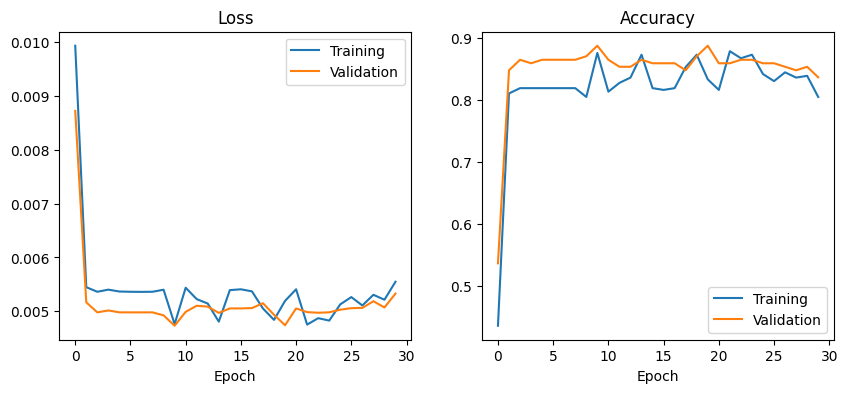

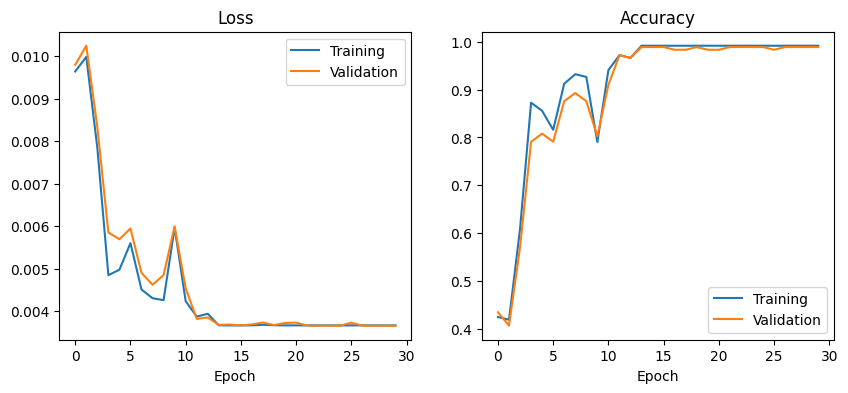

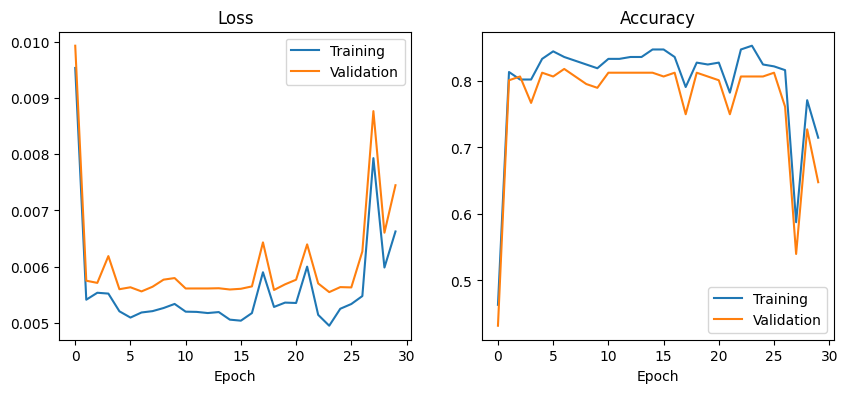

In [207]:
epochs = 30
lr = 0.001
weight_decay = 0
batch_size = 100

KFoldCrossValidation(stgcn, 3, X_falls, X_non_falls, test_data, test_labels, 'adam', lr, batch_size, epochs, weight_decay, False, 
                     num_class=2, window_size=45, num_point=17, graph=A, layer_config=default_layer_config, learnable_edges=True)

Training Loss: 0.0055: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


Training loss: 0.005519710774496784
Validation loss: 0.018371517008001156
Training accuracy: 0.8169291338582677
Validation accuracy: 0.9090909090909091


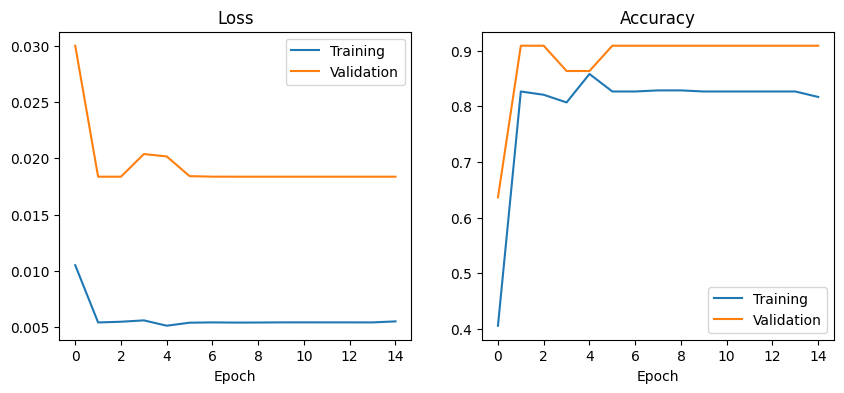

In [212]:
model = None
model = stgcn(num_class=2, window_size=45, num_point=17, graph=A, layer_config=default_layer_config, learnable_edges=True)
model.to(device)

epochs = 15
lr = 0.001
weight_decay = 0
batch_size = 100
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
training_loader = torch.utils.data.DataLoader(training_set, batch_sampler=BalancedBatchSampler(training_set))
train_eval_loader = torch.utils.data.DataLoader(training_set, batch_size=100, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=100, shuffle=False)

train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

progress = tqdm(np.arange(epochs))
for n in progress:
    model.train()
    for X_batch, y_batch in training_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.type(torch.LongTensor).to(device)

        y_pred = model(X_batch)
        batch_loss = loss_func(y_pred, y_batch)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    train_loss, train_acc = evaluate(model, train_eval_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    val_loss, val_acc = evaluate(model, validation_loader)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    progress.set_description(f'Training Loss: {train_loss:.4f}')

x_axis = np.arange(epochs)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(x_axis, train_loss_list, label="Training")
axes[0].plot(x_axis, val_loss_list, label="Validation")
axes[0].set_title("Loss")
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[1].plot(x_axis, train_acc_list, label='Training')
axes[1].plot(x_axis, val_acc_list, label='Validation')
axes[1].set_title("Accuracy")
axes[1].set_xlabel('Epoch')
axes[1].legend()

print(f"Training loss: {train_loss_list[-1]}")
print(f"Validation loss: {val_loss_list[-1]}")
print(f"Training accuracy: {train_acc_list[-1]}")
print(f"Validation accuracy: {val_acc_list[-1]}")

In [213]:
acc, results = eval.evaluate(model, device, testset=([data[:3] for data in test_data], test_labels), profile=True)

100%|██████████| 20/20 [00:17<00:00,  1.12it/s]

False positives: ['home video (51)']
False negatives: []
Accuracy: 0.95


In [185]:
[data[0] for data in test_data]

['coffee_room video (58)',
 'coffee_room video (10)',
 'coffee_room video (32)',
 'coffee_room video (45)',
 'coffee_room video (60)',
 'coffee_room video (4)',
 'coffee_room video (20)',
 'coffee_room video (7)',
 'coffee_room video (31)',
 'coffee_room video (59)',
 'coffee_room video (50)',
 'coffee_room video (29)',
 'coffee_room video (69)',
 'coffee_room video (67)',
 'home video (30)',
 'home video (25)',
 'home video (58)',
 'home video (51)',
 'home video (40)',
 'home video (45)']

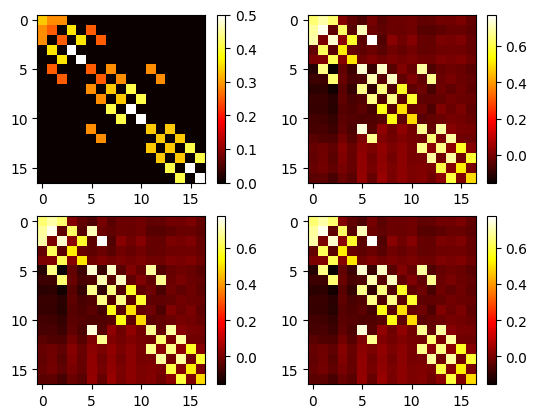

In [214]:
def undo_symnorm(A_symnorm, A):
    """Undo symmetric normalization on an adjacency matrix

    Args:
        A_symnorm: symnormed adjacency matrix

    Returns:
        A: original adjacency matrix
    """
    D = np.diag(np.sum(A, axis=0))
    D_sqrt = np.sqrt(D)
    return D_sqrt @ A_symnorm @ D_sqrt

fig, ax = plt.subplots(2, 2)

im = ax[0][0].imshow(A[0], cmap='hot', interpolation='nearest')
fig.colorbar(im, ax=ax[0][0])
im = ax[0][1].imshow(undo_symnorm(model.layers[0].sgcn.A[0].cpu().detach().numpy(), get_adjacency(edges, 17)), cmap='hot', interpolation='nearest')
fig.colorbar(im, ax=ax[0][1])
im = ax[1][0].imshow(undo_symnorm(model.layers[1].sgcn.A[0].cpu().detach().numpy(), get_adjacency(edges, 17)), cmap='hot', interpolation='nearest')
fig.colorbar(im, ax=ax[1][0])
im = ax[1][1].imshow(undo_symnorm(model.layers[2].sgcn.A[0].cpu().detach().numpy(), get_adjacency(edges, 17)), cmap='hot', interpolation='nearest')
fig.colorbar(im, ax=ax[1][1])

plt.show()

In [ ]:
torch.save(model.state_dict(), 'le2i_96acc_default.pth')

# Test on unseen data

In [18]:
LEC_ROOM_DIR = "D:\ASH\datasets\Le2i-skeleton\Lecture room\Skeletons_full"
OFFICE_DIR = "D:\ASH\datasets\Le2i-skeleton\Office\Skeletons_full"

lec_room = eval.load_data(LEC_ROOM_DIR)
lec_room = [('lec_room ' + data[0], data[1], data[2]) for data in lec_room]
    
office = eval.load_data(OFFICE_DIR)
office = [('office ' + data[0], data[1], data[2]) for data in office]

In [196]:
unseen_test_data = lec_room + office
unseen_test_labels = eval.LEC_ROOM_LABELS + eval.OFFICE_LABELS

In [ ]:
cleaned_data = []
cleaned_labels = []
for i, data in enumerate(unseen_test_data):
    frame_ids = data[2]
    count = 0
    for j in range(1, len(frame_ids)):
        count += frame_ids[i] - frame_ids[i - 1] - 1
    if count > 5:
        print(data[0])
    else:
        cleaned_data.append(data)
        cleaned_labels.append(unseen_test_labels[i])
        

In [ ]:
KFoldCrossValidation(stgcn, 3, X_falls, X_non_falls, unseen_test_data, unseen_test_labels, 'adam', lr, batch_size, epochs, weight_decay, False, 
                     num_class=2, window_size=45, num_point=17, graph=A, layer_config=my_config)

In [215]:
stride = 1
test_acc, test_results = eval.evaluate(model, device, testset=([data[:3] for data in unseen_test_data], unseen_test_labels), profile=True, stride=stride)

100%|██████████| 60/60 [00:16<00:00,  3.60it/s]

False positives: ['lec_room video (16)', 'lec_room video (17)', 'lec_room video (19)', 'lec_room video (20)', 'lec_room video (21)', 'lec_room video (22)', 'lec_room video (23)', 'lec_room video (24)', 'lec_room video (25)', 'lec_room video (26)', 'lec_room video (27)', 'office video (19)', 'office video (23)', 'office video (25)', 'office video (30)']
False negatives: ['office video (13)']
Accuracy: 0.7333333333333333


In [ ]:
[data[0] for data in unseen_test_data]

In [123]:
sample = unseen_test_data[21]
# sample = test_data[1]

batch = eval.create_batch(sample[1])

In [ ]:
start_frame = 140
joints = np.transpose(batch[start_frame], (1, 2, 0))

# Create a figure and axis
fig, ax = plt.subplots()
scatter = ax.scatter([], [])
lines = LineCollection([], color='red')
ax.add_collection(lines)
ax.set_title('{} frames'.format(len(joints)))

# Set axis limits
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.invert_yaxis()  # Invert y-axis

# Update function for animation
def update(frame):
    scatter.set_offsets(joints[frame])
    segments = []
    for joint1, joint2 in edges:
        x_values = [joints[frame][joint1][0], joints[frame][joint2][0]]
        y_values = [joints[frame][joint1][1], joints[frame][joint2][1]]
        segments.append([(x_values[0], y_values[0]), (x_values[1], y_values[1])])
    lines.set_segments(segments)
    return scatter, lines

# Create animation
ani = FuncAnimation(fig, update, frames=len(joints), blit=True)

# Save animation as GIF
ani.save(f'fall_frame_{start_frame}.gif', fps=25)


In [88]:
model.eval()
with torch.no_grad():
    batch_tensor = torch.tensor(batch).to(device)
    pred = model(batch_tensor).cpu()
results = torch.argmax(pred, axis=-1).numpy()

In [ ]:
condition = pred[:, 1] > pred[:, 0]
indices = torch.nonzero(condition, as_tuple=True)[0]
indices

# Visualization

In [100]:
import time

In [105]:
filename, skeletons, frame_ids = test_data[16]
print(filename)
start_time = time.time()
batch = eval.create_batch(skeletons)
model.eval()
with torch.no_grad():
    batch_tensor = torch.tensor(batch).to(device)
    pred = model(batch_tensor).cpu()
results = torch.argmax(pred, axis=-1).numpy()
runtime = time.time() - start_time
print(f"Inference time on {len(batch)} sub-sequences: {runtime}. The average time: {runtime / len(results)}")

home video (18)
Inference time on 54 sub-sequences: 0.18766117095947266. The average time: 0.003475206869619864


In [106]:
# This is an example, replace it with your video path
video_path = "D:\ASH\datasets\Le2i\Home_all\Videos\\video (18).avi"
cap = cv2.VideoCapture(video_path)

output_video_path = 'output_video.avi'  # Path to save the output video
frame_width = 320  # Width of the frames in the video
frame_height = 240  # Height of the frames in the video
fps = 25  # Frames per second
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Specify the codec
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

frame_ptr = 0
curr_frame = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    position = (10, 10)  # Coordinates of the upper left corner
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = (255, 255, 255)
    text = "N/A"
    
    if frame_ptr < len(frame_ids) and frame_ids[frame_ptr] == curr_frame:
        pred_idx = frame_ptr - 45 + 1
        if pred_idx >= 0 and pred_idx < len(results):
            pred = results[pred_idx]
            if pred == 1:
                text = "Fall"
                font_color = (0, 0, 255)
            else:
                text = "No fall"
                font_color = (0, 255, 0)
            
        # Example joint coordinates for one person in the frame
        # Replace this with your actual detection data
        # Format: [x, y, confidence]
        joints = skeletons[frame_ptr]
        
        # Draw joints
        for joint in joints:
            # Convert coordinates to integers
            x, y = int(joint[0]), int(joint[1])
            cv2.circle(frame, (x, y), 4, (0, 0, 255), -1)
        
        # Draw skeleton
        for bone in edges:
            # Convert coordinates to integers
            start_point, end_point = joints[bone[0]], joints[bone[1]]
            start_point = (int(start_point[0]), int(start_point[1]))
            end_point = (int(end_point[0]), int(end_point[1]))
            cv2.line(frame, start_point, end_point, (255, 0, 0), 2)
        
        frame_ptr += 1
    
    cv2.putText(frame, text, position, font, font_scale, font_color, thickness=2)

    # Display the frame with drawn joints and connections
    cv2.imshow('Frame', frame)
    out.write(frame)
    
    # if frame_ptr >= len(results): break 
    
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

    
    curr_frame += 1

# Release everything if job is finished
out.release()
cap.release()
cv2.destroyAllWindows()